In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
# import matplotlib.cm
import seaborn as sns
import cv2
import os

rim_path = "/home/marc/git/scratch/Supermarkt/enrichment_csv/Supermarket_Demo_2021_REFERENCE-IMAGE-MAPPER_Coffee_-_long_scanning_csv"
ref_img_path = "/home/marc/git/scratch/Supermarkt/reference_images/coffee.jpg"

In [88]:
scaling_factor = 0.5

ref_img = cv2.imread(ref_img_path)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_RGB2BGR)
ref_img = cv2.resize(ref_img, dsize=None, fx=scaling_factor, fy=scaling_factor)

gaze = pd.read_csv(os.path.join(rim_path, "gaze.csv"))
gaze["gaze position in reference image x [pixel]"] *= scaling_factor
gaze["gaze position in reference image y [pixel]"] *= scaling_factor

sections = pd.read_csv(os.path.join(rim_path, "sections.csv"))

aois = {
    "jacobs_default": ((0, 80), 372, 264),
    "jacobs_mild": ((368, 83), 222, 259),
    "jacobs_balance": ((593, 71), 184, 274),
    "jacobs_kräftig": ((779, 73), 198, 274),
    "jacobs_entkoffeiniert": ((978, 79), 193, 271),
    "cafe_intencion": ((1169, 81), 208, 271),
    "bio": ((1368, 84), 208, 268),
    "dallmayr_bohnen": ((1567, 88), 236, 264),
    "jacobs_aroma": ((1788, 91), 227, 266),
    "dallmayr_default": ((72, 391), 347, 240),
    "dallmayr_naturmild": ((419, 400), 194, 235),
    "dallmayr_entkoffeiniert": ((612, 395), 181, 243),
    "dallmayr_ethiopia": ((795, 403), 178, 236),
    "dallmayr_classic": ((974, 404), 190, 236),
    "dallmayr_gran_verde": ((1156, 401), 176, 243),
    "mövenpick": ((1329, 403), 192, 241),
    "lavazza_italiano": ((1523, 409), 348, 236),
    "melitta_klassisch": ((105, 677), 179, 209),
    "melitta_klassisch_mild": ((283, 682), 177, 204),
    "melitta_entoffeiniert": ((467, 682), 172, 212),
    "melitta_mild": ((636, 680), 181, 216),
    "melitta_intensiv": ((819, 688), 171, 207),
    "melitta_jahres": ((990, 688), 181, 214),
    "melitta_montana": ((1174, 688), 175, 219),
    "idee": ((1347, 691), 193, 214),
    "lavazza_rossa": ((1535, 698), 281, 208),
    "jacobs_mild_sanft": ((134, 930), 166, 188),
    "jacobs_klassisch": ((301, 934), 154, 185),
    "jacobs_meister": ((462, 938), 166, 189),
    "ja_kräftig": ((631, 942), 172, 195),
    "ja_mild": ((801, 942), 164, 191),
    "ja_entkoffeiniert": ((961, 944), 170, 192),
    "eilles_1": ((1127, 947), 148, 192),
    "eilles_2": ((1270, 954), 177, 188),
    "lavazze_crema": ((1439, 962), 302, 185),
}

In [71]:
r = cv2.selectROI(ref_img)
print("\"\":",((r[0], r[1]), r[2], r[3]),",")
cv2.destroyAllWindows()

"": ((943, 363), 191, 180) ,


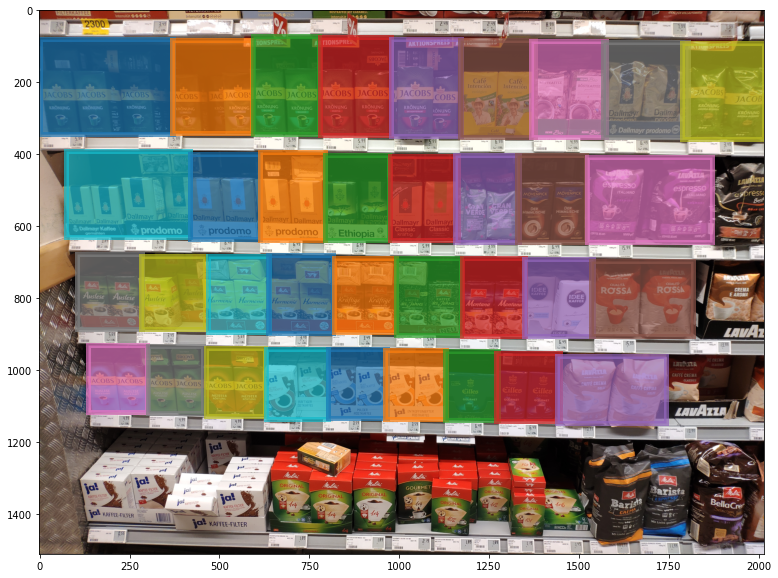

In [89]:
def draw_ref_and_aois(colors = None, fill=False):
    plt.figure(figsize=(20,10))
    
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        
    plt.imshow(ref_img)
    ax = plt.gca()

    for idx, aoi in enumerate(aois.values()):
        edgecolor = colors[idx % len(colors)]
        facecolor = colors[idx % len(colors)] if fill else "none"
        alpha = .7 if fill else 1.0
        rect = patches.Rectangle(*aoi, linewidth=5, edgecolor=edgecolor, facecolor=facecolor, alpha=alpha)
        ax.add_patch(rect)

draw_ref_and_aois(fill=True)

## Map gaze to AOIs

In [90]:
for key, aoi in aois.items():
    gaze[key] = False
    (x, y), width, height = aoi
    
    x_check = gaze["gaze position in reference image x [pixel]"].between(x, x + width)
    y_check = gaze["gaze position in reference image y [pixel]"].between(y, y + height)
    gaze.loc[gaze["gaze detected in reference image"], key] =  x_check & y_check

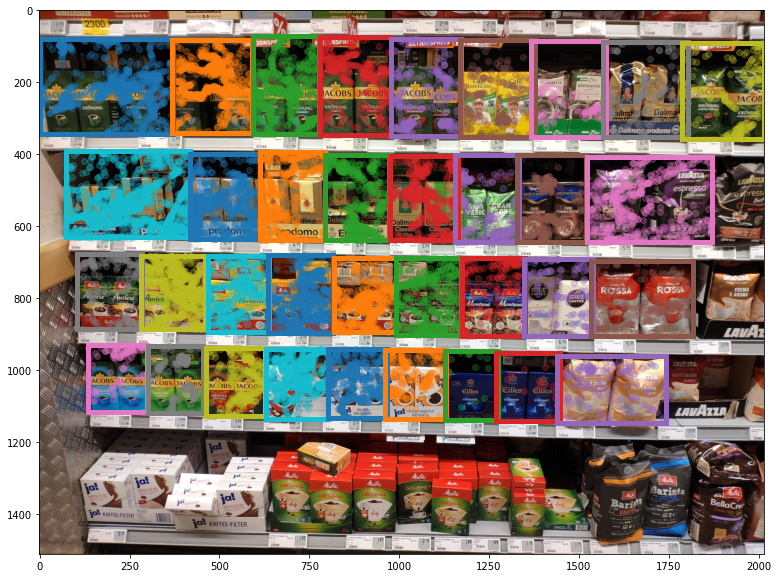

In [91]:
draw_ref_and_aois()

for idx, (key, aoi) in enumerate(aois.items()):    
    d = gaze[gaze[key]]
    plt.scatter(d["gaze position in reference image x [pixel]"], d["gaze position in reference image y [pixel]"], alpha=0.3, label=key)
# plt.legend()

## Dwell Time

In [112]:
def val2color(df, vmax=None):
    if vmax is None:
        vmax = results.max()
    
    norm = mpl.colors.Normalize(vmin=results.min(), vmax=vmax)
    cmap = mpl.cm.magma
    m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = []
    for v in results.values:
        colors.append(m.to_rgba(v))
    colors = np.vstack(colors)
    
    return colors, m

Text(0.5, 1.0, 'Raw Dwell Time')

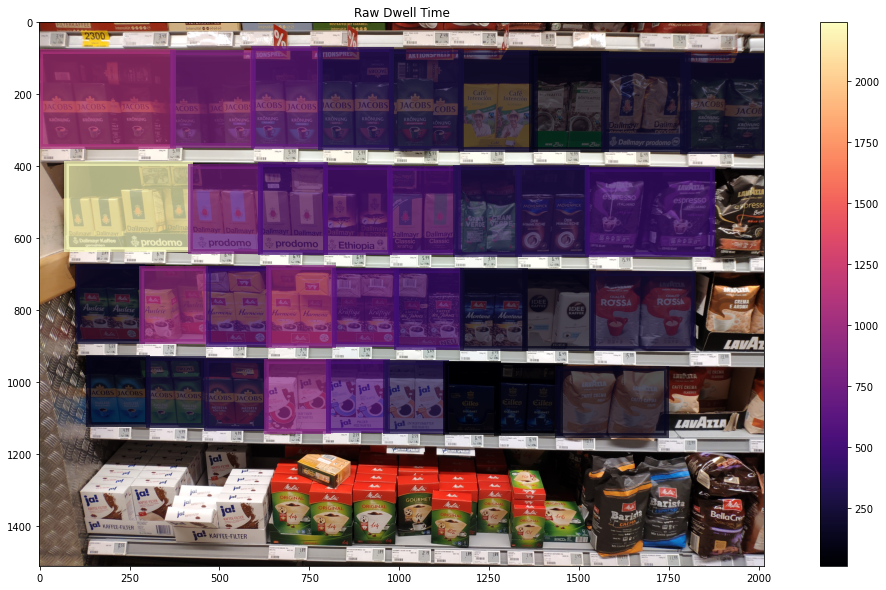

In [104]:
results = {}

for key in aois.keys():
    results[key] = len(gaze[gaze[key]])
results = pd.DataFrame(data = results.values(), index=results.keys(), columns=["Count"])

colors, cm = val2color(results)
    
draw_ref_and_aois(colors, fill=True)

plt.colorbar(cm)
plt.title("Raw Dwell Time")

Text(0.5, 1.0, 'Dwell Time normalized by Size')

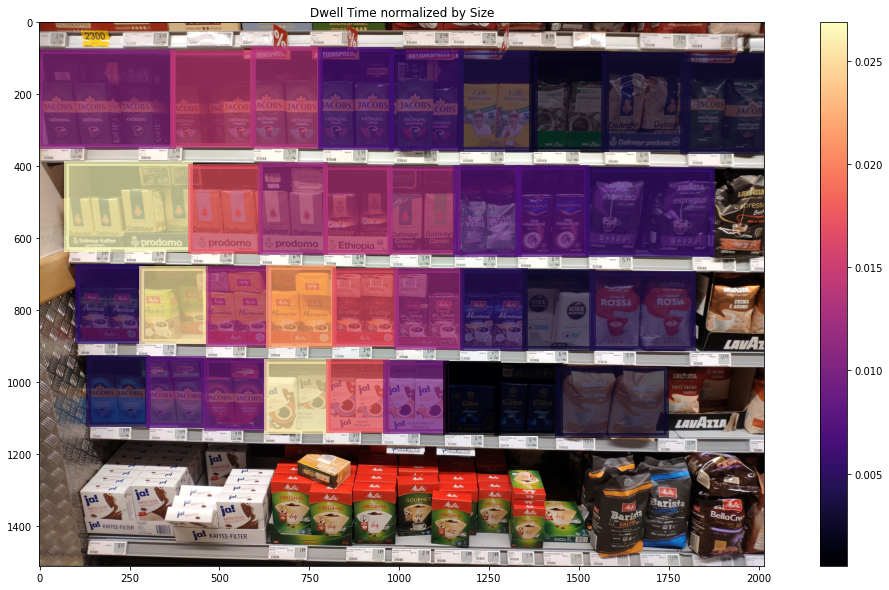

In [105]:
results = {}

for key, aoi in aois.items():
    results[key] = len(gaze[gaze[key]]) / (aoi[1] * aoi[2])
results = pd.DataFrame(data = results.values(), index=results.keys(), columns=["Count"])

colors, cm = val2color(results)
    
draw_ref_and_aois(colors, fill=True)

plt.colorbar(cm)
plt.title("Dwell Time normalized by Size")

## Reach

Text(0.5, 1.0, 'Reach - Percentage of subjects looking at the AOI')

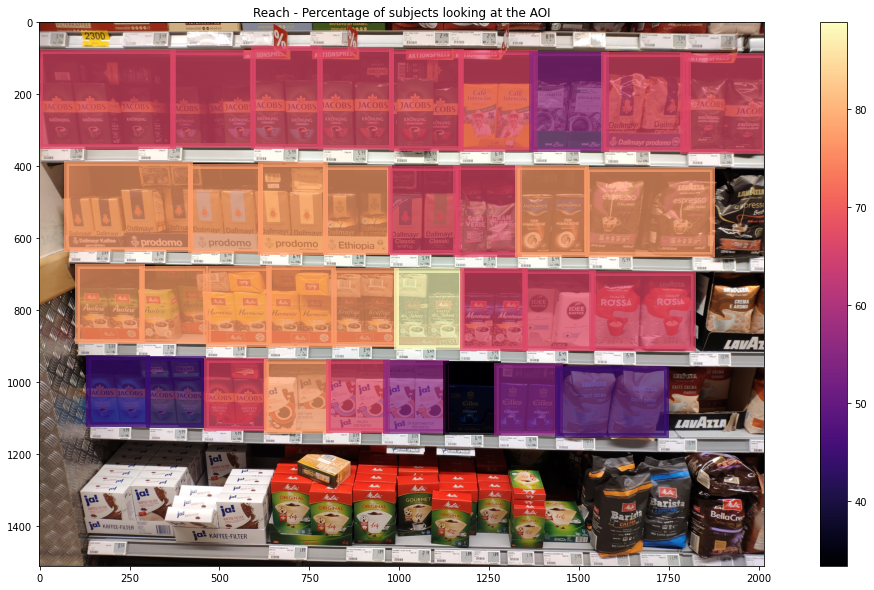

In [115]:
df = pd.merge(gaze, sections, left_on="section id", right_on="section id")

results = {}
for key, aoi in aois.items():
    results[key] = df.groupby("wearer id")[key].max().sum() / df["wearer id"].nunique() * 100
results = pd.DataFrame(data = results.values(), index=results.keys(), columns=["Ratio"])

colors, cm = val2color(results)
    
draw_ref_and_aois(colors, fill=True)

plt.colorbar(cm)
plt.title("Reach - Percentage of subjects looking at the AOI")

## Time to first contact

Text(0.5, 1.0, 'Time to first contact')

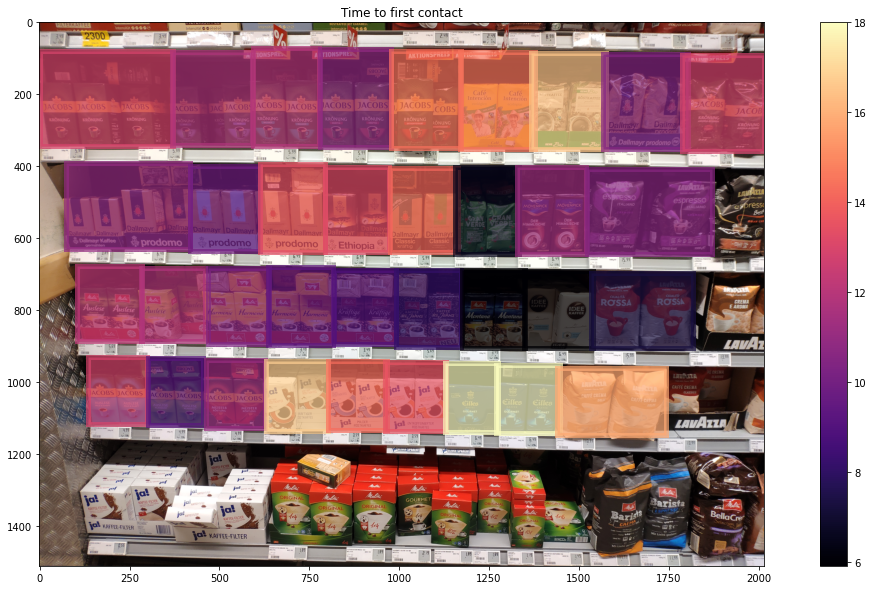

In [114]:
df = pd.merge(gaze, sections, left_on="section id", right_on="section id")
df["timestamp [ns]"] = df["timestamp [ns]"] - df["section start time [ns]"]

results = {}
for key, aoi in aois.items():
    def time_to_first_contact(df):
        df = df[df[key]]
        return df["timestamp [ns]"].min() / 1e9
    
    results[key] = df.groupby("wearer id").apply(time_to_first_contact).mean()
results = pd.DataFrame(data = results.values(), index=results.keys(), columns=["Ratio"])

colors, cm = val2color(results, vmax=18)
    
draw_ref_and_aois(colors, fill=True)

plt.colorbar(cm)
plt.title("Time to first contact")